# imports

In [77]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import numpy as np

# input data

In [78]:
# funtions to preprocess data
def mapping_2_df(actual_df,predicted_df,hit_threadhold = 0.5):
    result = pd.merge(actual_df,predicted_df, on=['video_id','action_id'],how='left',suffixes=('_g', '_p'))
    result['diff_start'] = abs(result['start_g']-result['start_p'])
    result['diff_end'] = abs(result['end_g']-result['end_p'])
    # filter out condition
    result['is_filtered'] = (result['diff_start'] >10) | (result['diff_end']>10)
    # calculate intersection time
    result['i_start'] = np.where(~result['is_filtered'], result[['start_g', 'start_p']].max(axis=1), np.nan)
    result['i_end'] = np.where(~result['is_filtered'], result[['end_g', 'end_p']].min(axis=1), np.nan)
    # calculate union time
    result['u_start'] = np.where(~result['is_filtered'] 
                                 & ((result['i_end']- result['i_start']) >0) 
                                 , result[['start_g', 'start_p']].min(axis=1), np.nan)
    result['u_end'] = np.where(~result['is_filtered'] 
                                 & ((result['i_end']- result['i_start']) >0) 
                                 , result[['end_g', 'end_p']].max(axis=1), np.nan)
    # calculate IoU
    result['intersection'] = result['i_end'] - result['i_start']
    result['union'] = result['u_end'] - result['u_start']
    result['iou'] = np.where(~result['is_filtered'] 
                             & result['union']>0,result['intersection']/result['union'],0)
    # flag hit base on threadhold
    result['is_hit'] = np.where(result['iou'] >= hit_threadhold,1,0)
    return result





In [79]:
# mapping df base on video_id and start
def mapping_2_df_by_time(actual_df,predicted_df,hit_threadhold = 0.5,time_threadhold = 10):
    '''
        mapping 2 df by video_id
            after that, add filter column with gap 10s from the contest
        
    '''
    result = pd.merge(actual_df,predicted_df, on=['video_id'],how='left',suffixes=('_g', '_p'))
    result['diff_start'] = abs(result['start_g']-result['start_p'])
    result['diff_end'] = abs(result['end_g']-result['end_p'])
    # filter out condition
    result['is_filtered'] = (result['diff_start'] >time_threadhold) | (result['diff_end']>time_threadhold)
    result = result.loc[~result['is_filtered']]
    # calculate intersection time
    result['i_start'] = np.where(~result['is_filtered'], result[['start_g', 'start_p']].max(axis=1), np.nan)
    result['i_end'] = np.where(~result['is_filtered'], result[['end_g', 'end_p']].min(axis=1), np.nan)
    # calculate union time
    result['u_start'] = np.where(~result['is_filtered'] 
                                 & ((result['i_end']- result['i_start']) >0) 
                                 , result[['start_g', 'start_p']].min(axis=1), np.nan)
    result['u_end'] = np.where(~result['is_filtered'] 
                                 & ((result['i_end']- result['i_start']) >0) 
                                 , result[['end_g', 'end_p']].max(axis=1), np.nan)
    # calculate IoU
    result['intersection'] = result['i_end'] - result['i_start']
    result['union'] = result['u_end'] - result['u_start']
    result['iou'] = np.where(~result['is_filtered'] 
                             & result['union']>0,result['intersection']/result['union'],0)
    # flag hit base on threadhold
    result['is_hit'] = np.where(result['iou'] >= hit_threadhold,1,0)
    result = result.sort_values(['iou'],ascending=False).drop_duplicates(['video_id','action_id_p'])
    # result = result.loc[result['is_hit']==1]
    temp = actual_df[['video_id','action_id']]\
            .merge(
                result[['video_id','action_id_g','action_id_p']]                    
                ,left_on =['video_id','action_id']
                ,right_on=['video_id','action_id_g']
                ,how='left'
                ,suffixes=('_g', '_p'))
    temp['action_id_p'] = temp['action_id_p'].fillna(-1)
    action_label = pd.read_csv("data/Distracted_Activity_Class_definition.txt",sep=',')

    action_id_to_label = action_label.set_index('action_id')['Label'].to_dict()
    # display(action_label)
    # Map action_ids to labels in the DataFrame
    temp['action_label_g'] = temp['action_id'].map(action_id_to_label)
    temp['action_label_p'] = temp['action_id_p'].map(action_id_to_label)
    temp['action_label_g'] = temp['action_label_g'].fillna("-1")
    temp['action_label_p'] = temp['action_label_p'].fillna("-1")
    return temp



# calculate and plot the confustion matrix

****************************************************************************************************
A2_submission_old.txt
****************************************************************************************************
avg iou:  0.7012846009201423
hit = 128 | count = 150 | hit/count = 0.8533333333333334
****************************************************************************************************
final_submission.txt
****************************************************************************************************
avg iou:  0.7319503746234496
hit = 134 | count = 150 | hit/count = 0.8933333333333333


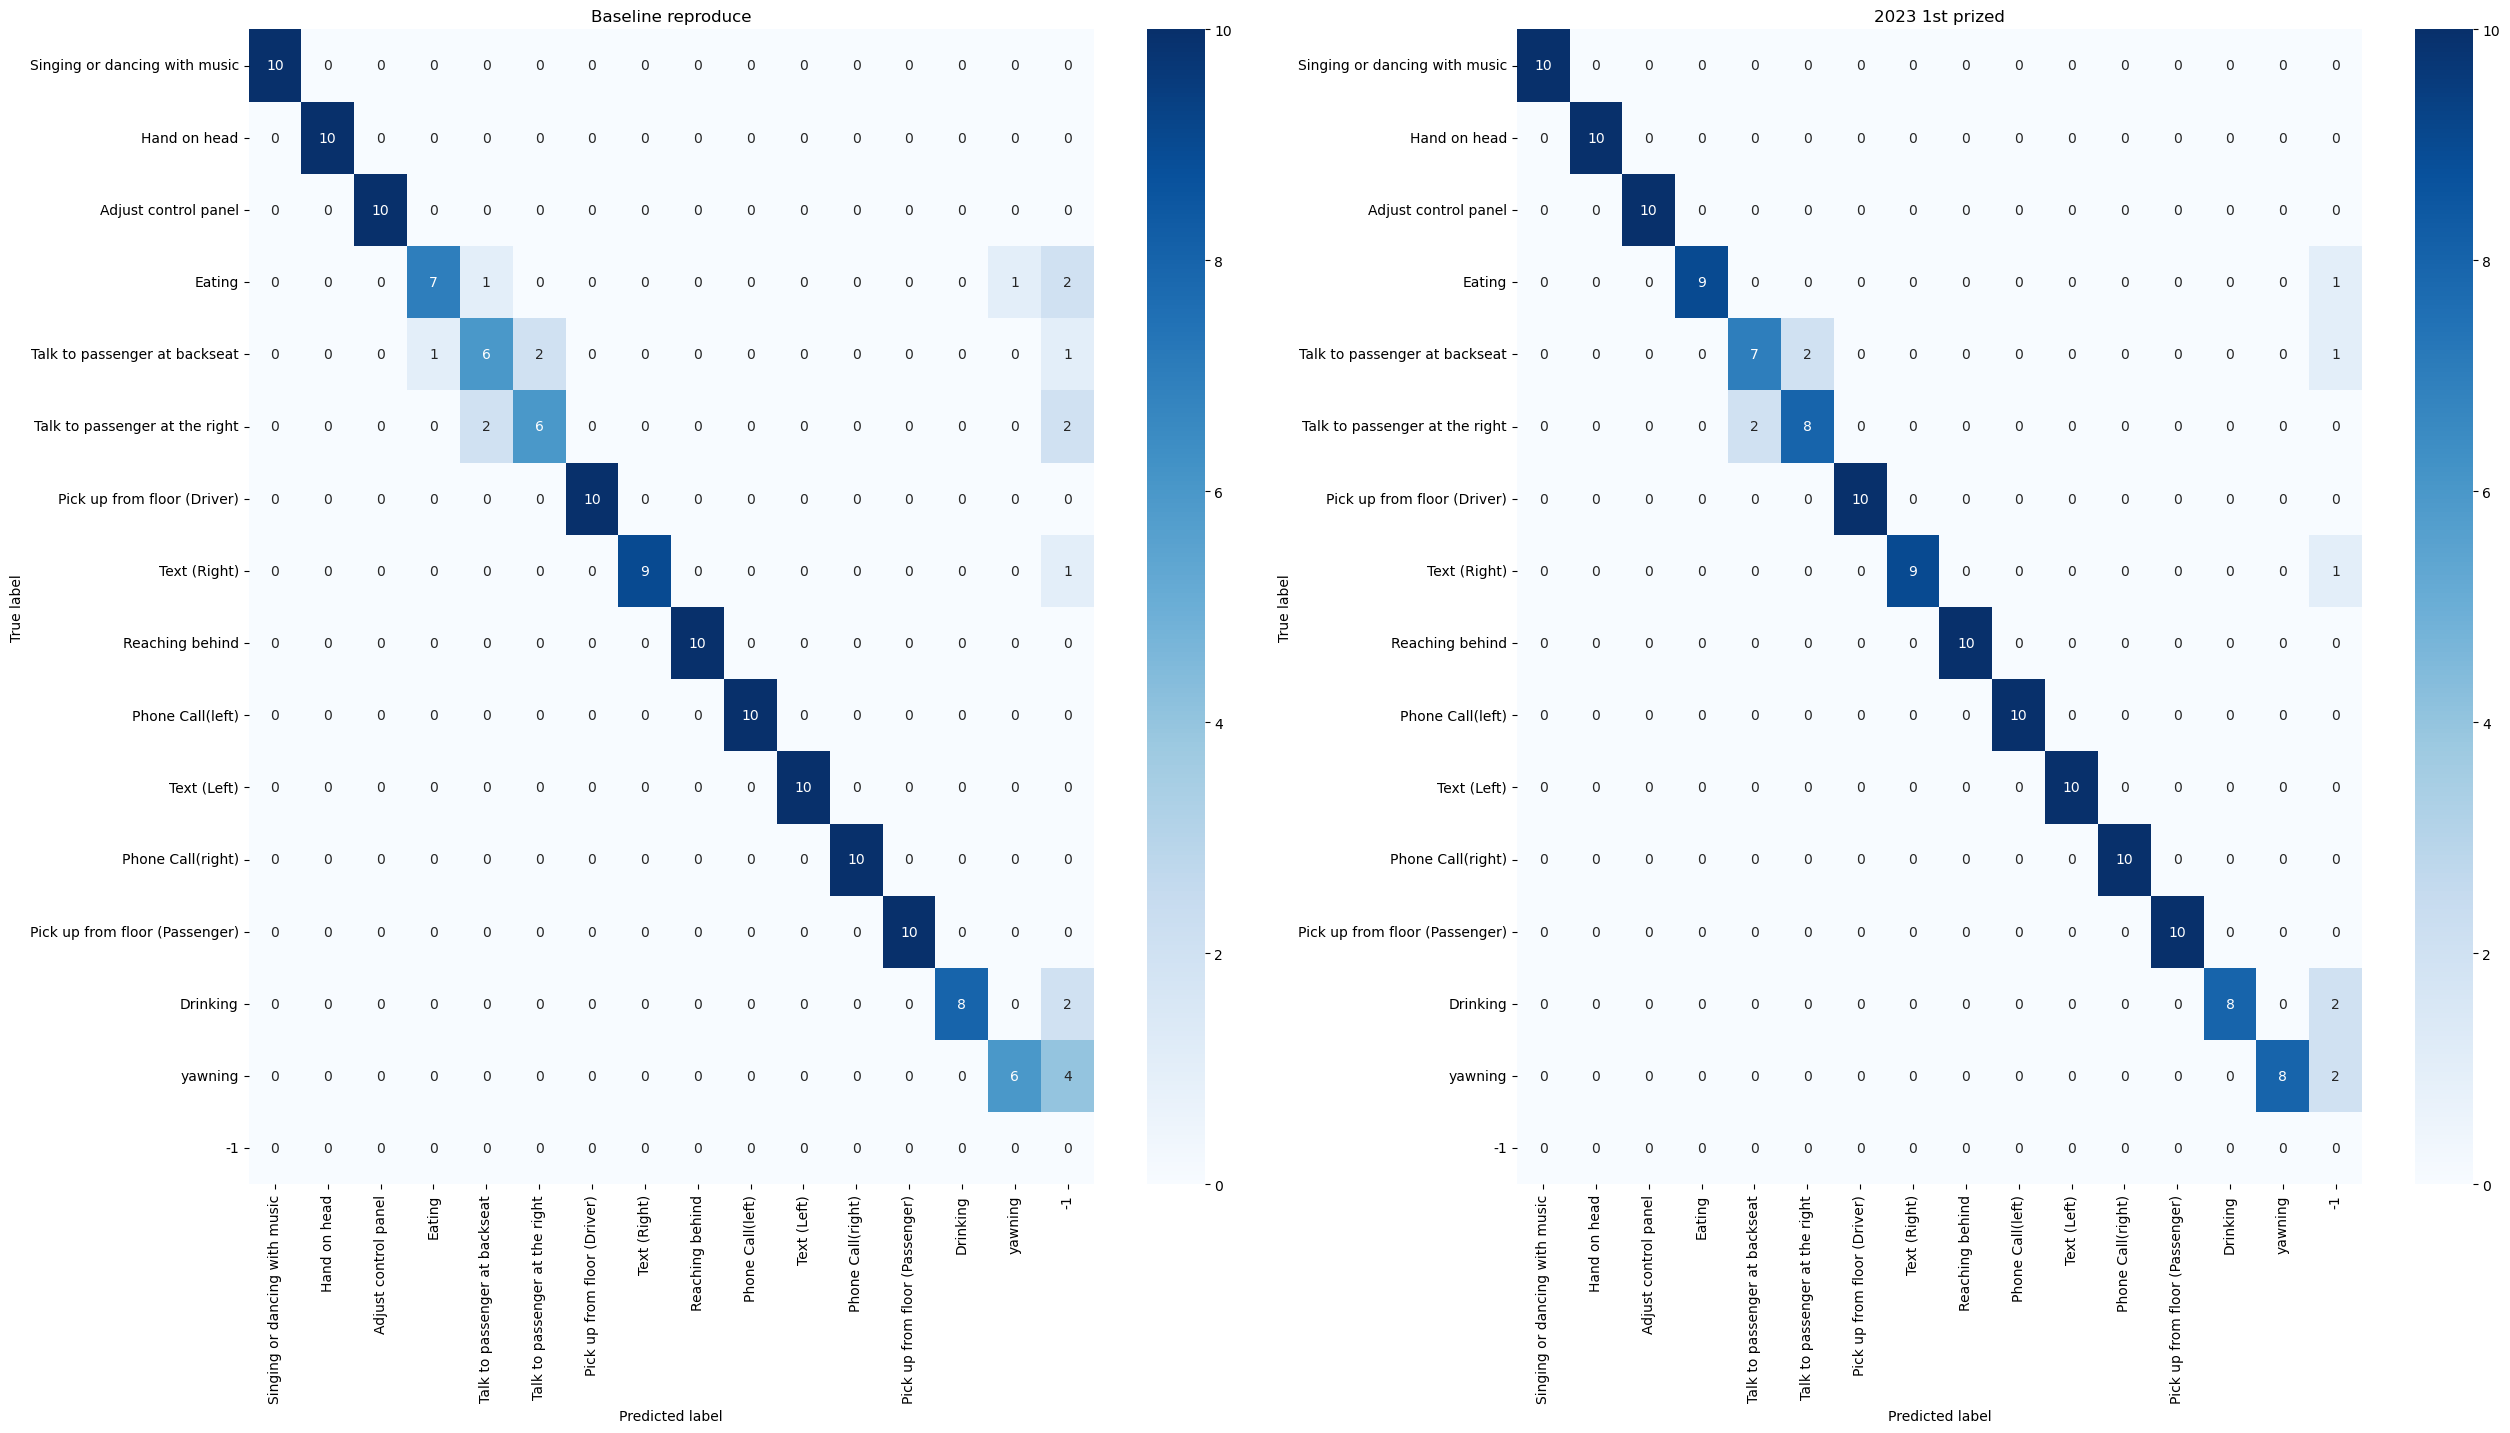

In [83]:


def cal_cm(y_true, y_pred):
    unique_labels = np.append(y_true.unique(), "-1")
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

    # Convert to DataFrame for easier plotting
    cm_df = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)
    return cm_df

def plot_confusion_matrices(confusion_matrices_dict,size=20):
    num_matrices = len(confusion_matrices_dict)

    # Create a figure with subplots based on the number of confusion matrices
    fig, axes = plt.subplots(1, num_matrices, figsize=(size * num_matrices, size))

    # If there's only one confusion matrix, make sure axes is a list
    if num_matrices == 1:
        axes = [axes]

    # Plot each confusion matrix
    for i, (title, cm_df) in enumerate(confusion_matrices_dict.items()):
        sns.heatmap(cm_df, annot=True, ax=axes[i], fmt='d', cmap='Blues',
                    xticklabels=cm_df.columns, yticklabels=cm_df.index)
        axes[i].set_title(title)
        axes[i].set_ylabel('True label')
        axes[i].set_xlabel('Predicted label')

    # Show the plot
    plt.show()



def benchmark_submit(df_ground_truth, csv_file_path = 'A2_submission_old.txt'):
    print("*"*100)
    print(csv_file_path)
    print("*"*100)
    df_baseline = pd.read_csv(csv_file_path,sep=' ')
    df_baseline.columns = ['video_id', 'action_id','start','end']

    preprocess = mapping_2_df(df_ground_truth,df_baseline)
    # display(preprocess)
    print("avg iou: ",preprocess['iou'].mean())
    print(f"hit = {preprocess['is_hit'].sum()} | count = {preprocess['is_hit'].count()} | hit/count = {preprocess['is_hit'].sum()/preprocess['is_hit'].count()}")

    test = mapping_2_df_by_time(df_ground_truth,df_baseline)
    # print(test.groupby('video_id').nunique())
    # display(test)
    return cal_cm(test['action_label_g'],test['action_label_p'])
    
# Load ground truth from Excel file
excel_file_path = 'data/A2/ground_truth_A2_manual_.xlsx'
df_ground_truth = pd.read_excel(excel_file_path,sheet_name='ground_truth_submit')



confusion_matrices_dict = {'Baseline reproduce': benchmark_submit(df_ground_truth,'A2_submission_old.txt'),
                           '2023 1st prized': benchmark_submit(df_ground_truth,'final_submission.txt')}
# Plot the confusion matrices
plot_confusion_matrices(confusion_matrices_dict,size=15)